In [38]:
# using Pkg
# Pkg.activate("")

# # Packages that you need
# packages_to_install = ["MLDatasets", "Plots", "Statistics", "Distributions", "Random", "Flux", "Yao", "FLOYao", "PythonCall", "BenchmarkTools", "Dates", "FiniteDifferences"]

# for pkg in packages_to_install
#     Pkg.add(pkg)
# end

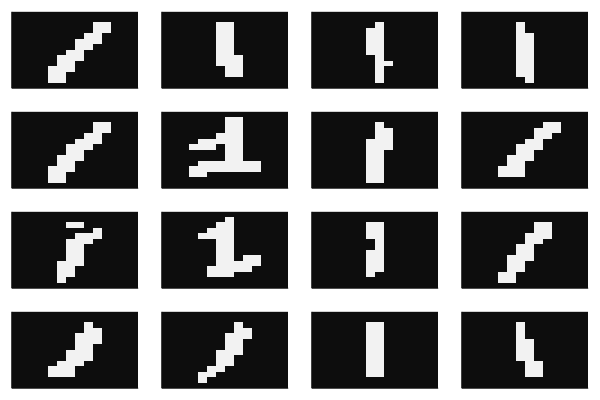

In [52]:
using MLDatasets
using Plots
using Statistics
using Distributions
using Random

train = 16 # Size of training dataset

digit = 1 # Digit to be learned
image_size = 28 # Size of image
compress_size = 14 # Size of compressed image

function compress(img, original, compress, max = true) #If max is false, then it does mean-convolution instead
    ratio = original ÷ compress
    compressed = zeros(compress, compress)
    a = []
    for i in 0:compress-1
        for j in 0:compress-1
            empty!(a)
            for p in 1:ratio
                for q in 1:ratio
                    push!(a, img[(ratio*i) + p, (ratio*j) + q])
                end
            end
            compressed[i+1, j+1] = max ? maximum(a) : mean(a)
        end
    end
    return compressed
end

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
trainstats = []
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, compress(rotl90(train_set[c][1]), image_size, compress_size) .> 0.5)
    push!(trainstats, sum(compress(train_set[c][1], image_size, compress_size) .> 0.5))
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...)

In [40]:
using Yao
using Flux

N = compress_size^2 #Number of qubits

d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid)) 

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 5
g = chain(N)
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.)) 
    end
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => Y), 0.))
    end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
dispatch!(g, rand(nparams).*2π)
println(parameters(g))

Number of parameters in discriminator: 181
Number of parameters in generator: 230
[2.0812942675305655, 5.7420998908280865, 3.1332045839719527, 3.2480567796093522, 1.9332958731055079, 2.783599240171453, 3.6604887760471705, 5.077622812503217, 4.473746149263735, 4.429056422069561, 1.5128984876985996, 2.927663460121124, 1.0807463112878095, 2.4598946503978403, 1.0319391648622336, 0.4684931375919043, 5.666107485096923, 1.71300885821313, 2.1541325233680944, 4.325419083037403, 2.4427848024481813, 4.640557344014839, 1.5693948365006336, 5.1641736291824705, 1.67595287075938, 1.572155487990375, 1.746517469912663, 3.6221778751106277, 1.8153144143935198, 1.661604825144338, 6.150977158184647, 0.6657185295730894, 5.412641645423796, 4.068810558218398, 3.5619544829146363, 5.659885404573078, 1.4527693629501506, 4.048816030010402, 2.7837784226565803, 0.9225365728269983, 5.635809114202271, 2.7042657498973237, 5.781890135570277, 2.6319118253874443, 5.008747945678802, 3.397302341250843, 6.178552558285267, 0.

μ: 6.5
σ: 0.9660917830792959
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

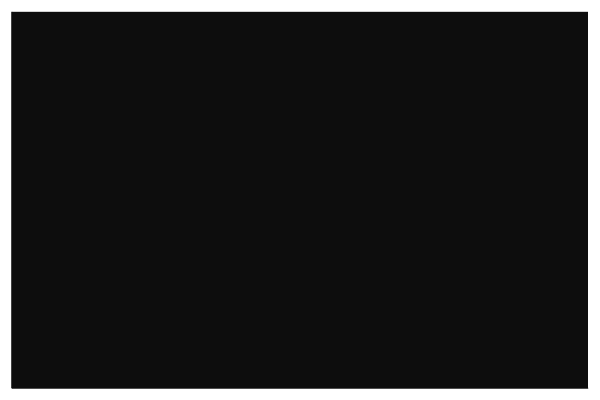

In [41]:
using FLOYao
using Random
using Distributions

mu = mean(trainstats)
sigma = std(trainstats)
println("μ: $mu")
println("σ: $sigma")
dist = Normal(mu, 1)

ratio = 0 
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, compress_size, compress_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [42]:
using Flux: train!
using Yao
using FLOYao
using Statistics

function postprocess(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

samplemean_batch = 500 #This doesn't need to be that big
dispatch!(g, rand(nparams).*2π)
function run_g(; theta = parameters(g), nbatch = samplemean_batch)
    dispatch!(g, theta)
    samples = []
    for i in 1:nbatch
        z = pprior() #MajoranaReg object
        result = z |> g |> measure |> postprocess
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples
end
#outputs an N * #samples matrix

function run_d_fake(samples)
    if size(samples)[1] != N #Require samples to be an N x #samples matrix
        println("Improper formatting of samples")
        return
    end
    samples |> d
end

function run_d_real() #Runs d on all training data
    samples = []
    for i in 1:train
        result = data_train[i] |> vec
        if i == 1
            samples = result
        else
            samples = hcat(samples, result)
        end
    end
    samples |> d
end

function gLoss(; theta = parameters(g), nbatch = samplemean_batch)
    -mean(log.(run_d_fake(run_g(theta = theta, nbatch = nbatch))))
end

function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior()
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end

gLoss()

0.87592435f0

In [44]:
using Yao
using FLOYao

function parametershift_grad(theta = parameters(g)) #Shift parameters in-place
    l = nparameters(g)
    temp_params = theta
    temp_params[1] += π/2
    grad = zeros(l)
    for i in 1:l
        plus = 0
        minus = 0
        dispatch!(g, temp_params)
        plus = gLoss()
        temp_params[i] -= π
        dispatch!(g, temp_params)
        minus = gLoss()
        grad[i] = (plus - minus) / 2
        if i < l
            temp_params[i] += π/2
            temp_params[i+1] += π/2
        end
    end
    temp_params[l] += π/2
    dispatch!(g, temp_params)
    grad
end

parametershift_grad (generic function with 2 methods)

In [45]:
g_lr = 1 
d_lr = 1e-3

d_opt = Flux.setup(Adam(), d) 

gLoss_vals = []
dLoss_vals = []
mean_grads = []
dreal_vals = []
dfake_vals = []
#Keep track of avg discriminator output on real vs. fake data and make sure none of them gets too small or too large
g_epochs = 10 
d_epochs = 3
epochs = 20
batch = train

for i in 1:epochs
    t = time()
    for j in 1:g_epochs
        ∇ = parametershift_grad()
        push!(mean_grads, mean(∇))
        dispatch!(-, g, ∇ * g_lr)
        push!(gLoss_vals, gLoss())
    end
    for j in 1:d_epochs
        real = []
        fake = []
        for m in 1:batch
            x = data_train[m] |> vec 
            push!(real, Int.(x))
            push!(fake, run_g(nbatch = 1))
        end
        data = collect(zip(real, fake)) 
        Flux.train!(dLoss, d, data, d_opt)
        s = 0
        for x in data
            s += dLoss(d, x[1], x[2])        
        end
        push!(dLoss_vals, s / batch)
    end
    d_fake = first(run_d_fake(run_g(nbatch = 1)))
    push!(dfake_vals, d_fake)
    index = rand(1:train)
    d_real = data_train[index] |> vec |> d |> first
    push!(dreal_vals, d_real)
    println("iteration $i done in: ", time() - t)
end

for _ in 1:g_epochs
    dispatch!(-, g, parametershift_grad() * g_lr)
    push!(gLoss_vals, gLoss())
end

iteration 1 done in: 77.90408086776733
iteration 2 done in: 

74.70763921737671


iteration 3 done in: 75.83261299133301
iteration 4 done in: 

71.17605805397034


iteration 5 done in: 72.29006791114807
iteration 6 done in: 

73.37513208389282


iteration 7 done in: 70.21771097183228
iteration 8 done in: 

71.20913791656494


iteration 9 done in: 70.54730606079102
iteration 10 done in: 

70.08394384384155


iteration 11 done in: 70.21837186813354
iteration 12 done in: 

73.46821403503418


iteration 13 done in: 72.4904248714447
iteration 14 done in: 

72.44716382026672


iteration 15 done in: 72.80667209625244
iteration 16 done in: 

1859.9334371089935


iteration 17 done in: 69.61799001693726
iteration 18 done in: 

70.62685894966125


iteration 19 done in: 71.97320818901062
iteration 20 done in: 

91.02499485015869


Generator loss
Any[0.8376865f0, 0.840451f0, 0.7858875f0, 0.7682875f0, 0.7462463f0, 0.7475341f0, 0.70242536f0, 0.71009344f0, 0.67857695f0, 0.66129005f0, 0.67282045f0, 0.6519058f0, 0.6296868f0, 0.65614945f0, 0.6312031f0, 0.62874746f0, 0.5909321f0, 0.6071248f0, 0.56679994f0, 0.576658f0, 0.6340046f0, 0.6137021f0, 0.61776215f0, 0.6054073f0, 0.6330458f0, 0.61413425f0, 0.59169596f0, 0.5913833f0, 0.58829194f0, 0.5736762f0, 0.66754484f0, 0.6606704f0, 0.65368444f0, 0.6495291f0, 0.64533687f0, 0.61815083f0, 0.6174892f0, 0.63245714f0, 0.61938f0, 0.62542266f0, 0.71552217f0, 0.70735216f0, 0.70036316f0, 0.690707f0, 0.6646461f0, 0.6260004f0, 0.6419676f0, 0.6259157f0, 0.6248002f0, 0.59697086f0, 0.7349139f0, 0.71201193f0, 0.6981965f0, 0.6896779f0, 0.6688731f0, 0.67180747f0, 0.6376267f0, 0.6402491f0, 0.63606757f0, 0.622808f0, 0.76850677f0, 0.75360787f0, 0.75778735f0, 0.7519829f0, 0.7316949f0, 0.72154814f0, 0.72092295f0, 0.6971125f0, 0.70751935f0, 0.67627984f0, 0.7168179f0, 0.7074081f0, 0.6625003f0, 0.6531

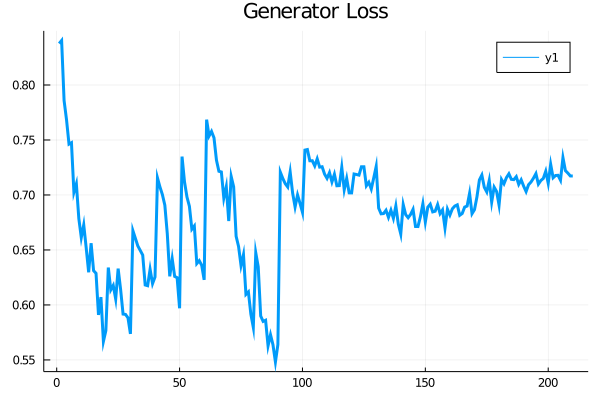

In [46]:
println("Generator loss")

println(gLoss_vals)
# for l in gLoss_values
#     println(l)
# end

plot(gLoss_vals, title = "Generator Loss", linewidth=3)

Discriminator loss
Any[1.6238625f0, 1.5271295f0, 1.4646393f0, 1.4563472f0, 1.438552f0, 1.4073925f0, 1.4544129f0, 1.3448198f0, 1.2277626f0, 1.328743f0, 1.2403681f0, 1.1915667f0, 1.2552391f0, 1.2255707f0, 1.2134637f0, 1.2401702f0, 1.2093349f0, 1.1768938f0, 1.1806885f0, 1.1485133f0, 1.1188259f0, 1.3263056f0, 1.2928774f0, 1.2717634f0, 1.3716311f0, 1.3255366f0, 1.3657781f0, 1.3461609f0, 1.337291f0, 1.3550178f0, 1.3533778f0, 1.3328941f0, 1.3423431f0, 1.3242933f0, 1.3270819f0, 1.3535188f0, 1.3181502f0, 1.3262815f0, 1.3256423f0, 1.312875f0, 1.326265f0, 1.3205172f0, 1.3376927f0, 1.3591425f0, 1.3312138f0, 1.33265f0, 1.3231504f0, 1.3493147f0, 1.3334382f0, 1.3383393f0, 1.3491898f0, 1.3516916f0, 1.3418071f0, 1.3499805f0, 1.3467531f0, 1.3346895f0, 1.3487451f0, 1.3425227f0, 1.341604f0, 1.3433607f0]


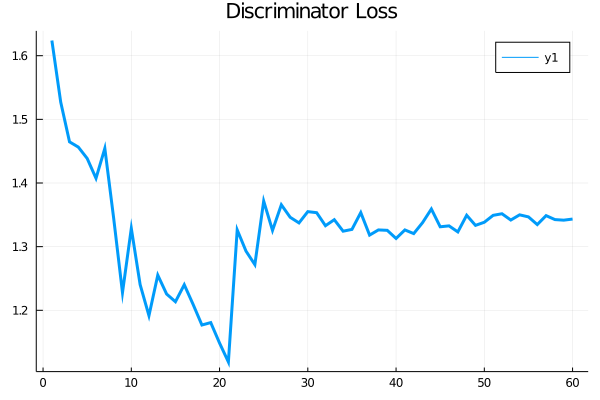

In [47]:
println("Discriminator loss")

println(dLoss_vals)
# for l in dLoss_values
#     println(l)
# end

plot(dLoss_vals, title = "Discriminator Loss", linewidth=3)

Mean gradients
Any[0.002087054563605267, -0.00023961119029832924, 0.0009005080098691194, 0.0012128706859505696, 0.00045412403085957404, 0.0015073948580285777, 0.0015439428713010705, 0.0013542943674585094, 0.0010586822810380355, 6.536828434985616e-5, 0.0010053256283635678, 0.0010127959044083305, 0.0003206895745318869, 0.001656722763310308, 0.0005334628664928933, 0.001397517193918643, -0.0003892629042915676, 0.0005863696336746216, 0.001168186120364977, 0.000875561263250268, -0.0005402955024138741, 0.0009874290746191275, -0.00020397033380425495, 0.0002891018338825392, 0.0011050172474073327, -0.0007467474626458209, -0.00033939558526744013, 0.001233757837958958, 0.0008144578208094058, 0.00036507585774297297, 9.257637936135997e-5, 0.0011197039614553037, 0.0001445974992669147, 0.00027028076026750647, -0.001202858401381451, -0.00017002535902935526, 1.0735573975936226e-5, 0.0006993248410846877, 0.000879358726999034, -0.0007361147714697796, 0.0013197406478550123, 0.0005602986916251805, 0.0006952

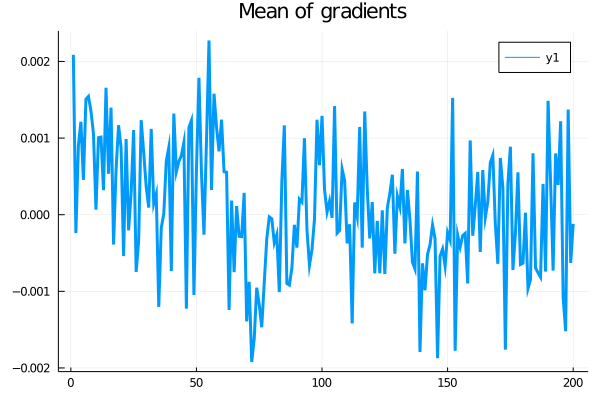

In [48]:
println("Mean gradients")

println(mean_grads)
# for l in dLoss_values
#     println(l)
# end

plot(mean_grads, title = "Mean of gradients", linewidth=3)

In [49]:
#Testing the Discriminator

d_fake = first(run_d_fake(run_g(nbatch = 1)))
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
d_real = data_train[index] |> vec |> d |> first
println("real data: $d_real") #Should print a number close to 1

fake data: 0.49061295
real data: 0.53734833


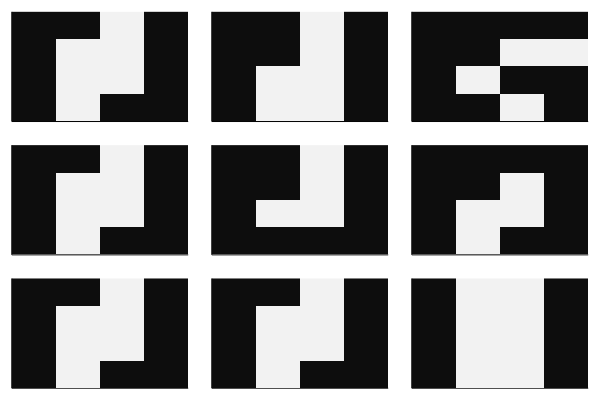

In [51]:
#Testing the Generator

nsamples = 9
samples = run_g(nbatch = nsamples)
plot([heatmap(reshape(samples[:, i], compress_size, compress_size), color=:grays, colorbar = false, ticks = false) for i in 1:nsamples]...)